In [ ]:
# train a generative adversarial network on a one-dimensional function
import pandas as pd
from numpy import hstack
import numpy as np
from datetime import datetime
from numpy import zeros
from numpy import ones
import random
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Conv1D, LeakyReLU, Reshape, UpSampling1D
from keras.optimizers import Adam
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from tqdm import tqdm
from tensorflow import keras
from keras.models import save_model, load_model
from statistics import mean, variance, pstdev
from sklearn.preprocessing import MinMaxScaler
from statistics import mean, variance, pstdev
from scipy.spatial import distance
from scipy.stats import wilcoxon
from dtaidistance import dtw
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec
import seaborn as sns
import math

In [ ]:
!pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LENGTH_INPUT = 288
latent_dim = 500

# Prepare training data

In [ ]:
df_575 =  pd.read_csv('/content/drive/MyDrive/Thesis/processed data/575.csv')

In [ ]:
df_575['time'] = pd.to_datetime(df_575['time'], dayfirst=True)

In [ ]:
df_575['date'] = df_575['time'].apply(lambda x: x.date())
dates = df_575['date'].unique()
glucose_575 = []
for date in dates:
  glucose_575.append(df_575[df_575['date'] == date]['glucose_value'].values)

In [ ]:
scaler = MinMaxScaler().fit(glucose_575)
glucose_575 = scaler.transform(glucose_575)

In [ ]:
glucose_575 = np.array(glucose_575)
y = ones((54, 1))

In [ ]:
glucose_575.shape

(54, 288)

# Model Architecture

In [ ]:
# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    
    # Dense layer
    model.add(Dense(1, input_shape=(288,1)))
    model.add(LeakyReLU())
    
    # Convolutional layer with LeakyReLU activation
    model.add(Conv1D(32, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU())

    # Convolutional layer with LeakyReLU activation
    model.add(Conv1D(32, kernel_size=2, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    # Reshape layer
    model.add(Reshape((2304,)))
    
    # Dense layer
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0005)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# define the standalone generator model
def define_generator():
    model = Sequential()
    
    # Dense layer
    model.add(Dense(3600, input_shape=(latent_dim,)))
    model.add(LeakyReLU())
    
    # Reshape layer
    model.add(Reshape((72, 50)))
    
    # Upsampling layer
    model.add(UpSampling1D(size=4))
    
    # Convolutional layer
    model.add(Conv1D(filters=32, kernel_size=2, strides=2, padding='same'))
    
    # Upsampling layer
    model.add(UpSampling1D(size=4))
    
    # Convolutional layer + leaky relu layer
    model.add(Conv1D(filters=32, kernel_size=2, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    # Convolutional layer
    model.add(Conv1D(filters=1, kernel_size=1, padding='same'))
    
    model.compile(optimizer='adam')

    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(n):
    # generate points in the latent space from the normal distribution
    x_input = np.random.normal(size = latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)

    return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
    # generate points in latent space
    x_input = generate_latent_points(n)
    # predict outputs
    X = generator.predict(x_input, verbose=0)
    # create class labels
    y = zeros((n, 1))

    return X, y

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=54, n_eval=100):
    d_loss_list = []
    g_loss_list = []
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in tqdm(range(n_epochs)):
        
        # prepare real samples
        rand_index = random.sample(range(0,54), 27)
        x_real, y_real = glucose_575[rand_index], y[rand_index]
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, half_batch)
        
        # update discriminator
        d_loss_real = d_model.train_on_batch(x_real, y_real)
        d_loss_fake = d_model.train_on_batch(x_fake, y_fake)
        # average of d_loss_real and d_loss_fake
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_loss_list.append(d_loss)
        #print(d_loss[0])

        # prepare points in latent space as input for the generator
        #for _ in range(4):
        x_gan = generate_latent_points(n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(x_gan, y_gan)
        g_loss_list.append(g_loss)
        
       
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            generator.save_weights('/content/drive/MyDrive/Thesis/model/normal_gan/575_0.0005/generator_weights_%d.h5' %(i+1))
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss))

In [ ]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288, 1)            2         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 288, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 144, 32)           160       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 32)            2080      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 72, 32)            0         
                                                                 
 reshape (Reshape)           (None, 2304)              0

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
generator = define_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3600)              1803600   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 3600)              0         
                                                                 
 reshape_1 (Reshape)         (None, 72, 50)            0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 288, 50)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 144, 32)           3232      
                                                                 
 up_sampling1d_1 (UpSampling  (None, 576, 32)          0         
 1D)                                                  

In [ ]:
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

  1%|          | 101/10000 [00:24<1:20:36,  2.05it/s]

99 [D loss: 0.526381, acc.: 50.00%] [G loss: 1.895699]


  2%|▏         | 201/10000 [00:33<36:07,  4.52it/s]

199 [D loss: 0.709484, acc.: 40.74%] [G loss: 0.636214]


  3%|▎         | 301/10000 [00:43<37:45,  4.28it/s]

299 [D loss: 0.670715, acc.: 100.00%] [G loss: 0.718218]


  4%|▍         | 401/10000 [00:52<27:03,  5.91it/s]

399 [D loss: 0.582217, acc.: 100.00%] [G loss: 0.720862]


  5%|▌         | 501/10000 [01:02<30:58,  5.11it/s]

499 [D loss: 0.624127, acc.: 66.67%] [G loss: 0.702010]


  6%|▌         | 601/10000 [01:12<49:11,  3.18it/s]

599 [D loss: 0.690509, acc.: 57.41%] [G loss: 0.916852]


  7%|▋         | 701/10000 [01:22<48:43,  3.18it/s]

699 [D loss: 0.548211, acc.: 87.04%] [G loss: 1.098867]


  8%|▊         | 802/10000 [01:32<27:55,  5.49it/s]

799 [D loss: 0.560078, acc.: 100.00%] [G loss: 0.747792]


  9%|▉         | 902/10000 [01:42<28:57,  5.24it/s]

899 [D loss: 0.479025, acc.: 98.15%] [G loss: 0.848596]


 10%|█         | 1002/10000 [01:52<28:33,  5.25it/s]

999 [D loss: 0.440033, acc.: 98.15%] [G loss: 1.254796]


 11%|█         | 1102/10000 [02:02<28:00,  5.29it/s]

1099 [D loss: 0.565071, acc.: 87.04%] [G loss: 0.825963]


 12%|█▏        | 1202/10000 [02:12<32:52,  4.46it/s]

1199 [D loss: 0.456616, acc.: 98.15%] [G loss: 0.882197]


 13%|█▎        | 1301/10000 [02:21<28:17,  5.12it/s]

1299 [D loss: 0.366184, acc.: 96.30%] [G loss: 1.196781]


 14%|█▍        | 1401/10000 [02:32<41:17,  3.47it/s]

1399 [D loss: 1.062015, acc.: 42.59%] [G loss: 0.337692]


 15%|█▌        | 1501/10000 [02:41<31:15,  4.53it/s]

1499 [D loss: 0.346650, acc.: 87.04%] [G loss: 1.313162]


 16%|█▌        | 1601/10000 [02:51<30:20,  4.61it/s]

1599 [D loss: 0.117744, acc.: 100.00%] [G loss: 3.170133]


 17%|█▋        | 1701/10000 [03:00<30:09,  4.59it/s]

1699 [D loss: 0.242365, acc.: 94.44%] [G loss: 1.593415]


 18%|█▊        | 1801/10000 [03:10<34:04,  4.01it/s]

1799 [D loss: 0.126374, acc.: 98.15%] [G loss: 3.095673]


 19%|█▉        | 1901/10000 [03:21<24:55,  5.41it/s]

1899 [D loss: 0.191360, acc.: 98.15%] [G loss: 1.728434]


 20%|██        | 2002/10000 [03:31<30:55,  4.31it/s]

1999 [D loss: 0.305720, acc.: 96.30%] [G loss: 1.330861]


 21%|██        | 2102/10000 [03:40<20:22,  6.46it/s]

2099 [D loss: 0.114035, acc.: 98.15%] [G loss: 2.304891]


 22%|██▏       | 2202/10000 [03:51<34:25,  3.78it/s]

2199 [D loss: 0.249075, acc.: 98.15%] [G loss: 1.467235]


 23%|██▎       | 2302/10000 [04:00<23:02,  5.57it/s]

2299 [D loss: 0.451894, acc.: 72.22%] [G loss: 3.330706]


 24%|██▍       | 2402/10000 [04:10<18:53,  6.70it/s]

2399 [D loss: 0.130064, acc.: 100.00%] [G loss: 2.208902]


 25%|██▌       | 2502/10000 [04:19<23:38,  5.29it/s]

2499 [D loss: 0.613986, acc.: 74.07%] [G loss: 1.022680]


 26%|██▌       | 2602/10000 [04:29<21:51,  5.64it/s]

2599 [D loss: 0.102235, acc.: 100.00%] [G loss: 2.589661]


 27%|██▋       | 2702/10000 [04:39<21:47,  5.58it/s]

2699 [D loss: 0.163039, acc.: 100.00%] [G loss: 1.958935]


 28%|██▊       | 2801/10000 [04:49<19:36,  6.12it/s]

2799 [D loss: 0.164773, acc.: 98.15%] [G loss: 2.092112]


 29%|██▉       | 2901/10000 [04:59<19:38,  6.03it/s]

2899 [D loss: 0.029997, acc.: 100.00%] [G loss: 3.299657]


 30%|███       | 3001/10000 [05:08<19:47,  5.89it/s]

2999 [D loss: 0.106843, acc.: 100.00%] [G loss: 2.203900]


 31%|███       | 3101/10000 [05:18<32:43,  3.51it/s]

3099 [D loss: 0.084534, acc.: 100.00%] [G loss: 2.454278]


 32%|███▏      | 3201/10000 [05:28<24:58,  4.54it/s]

3199 [D loss: 0.030203, acc.: 100.00%] [G loss: 3.471810]


 33%|███▎      | 3301/10000 [05:38<30:55,  3.61it/s]

3299 [D loss: 0.019189, acc.: 100.00%] [G loss: 4.037493]


 34%|███▍      | 3401/10000 [05:47<24:52,  4.42it/s]

3399 [D loss: 0.020754, acc.: 100.00%] [G loss: 6.890436]


 35%|███▌      | 3501/10000 [05:57<23:58,  4.52it/s]

3499 [D loss: 0.024944, acc.: 100.00%] [G loss: 3.623296]


 36%|███▌      | 3601/10000 [06:07<24:38,  4.33it/s]

3599 [D loss: 0.036550, acc.: 100.00%] [G loss: 3.447935]


 37%|███▋      | 3701/10000 [06:17<32:48,  3.20it/s]

3699 [D loss: 0.067404, acc.: 98.15%] [G loss: 3.280203]


 38%|███▊      | 3802/10000 [06:28<19:17,  5.35it/s]

3799 [D loss: 0.019027, acc.: 100.00%] [G loss: 3.677572]


 39%|███▉      | 3901/10000 [06:37<17:16,  5.88it/s]

3899 [D loss: 0.015405, acc.: 100.00%] [G loss: 4.086059]


 40%|████      | 4001/10000 [06:48<34:33,  2.89it/s]

3999 [D loss: 0.022898, acc.: 100.00%] [G loss: 3.949397]


 41%|████      | 4101/10000 [06:57<20:52,  4.71it/s]

4099 [D loss: 0.013716, acc.: 100.00%] [G loss: 4.268991]


 42%|████▏     | 4201/10000 [07:07<26:11,  3.69it/s]

4199 [D loss: 0.003947, acc.: 100.00%] [G loss: 5.291962]


 43%|████▎     | 4301/10000 [07:17<21:45,  4.36it/s]

4299 [D loss: 0.011101, acc.: 100.00%] [G loss: 4.454052]


 44%|████▍     | 4401/10000 [07:27<20:22,  4.58it/s]

4399 [D loss: 0.009238, acc.: 100.00%] [G loss: 5.020565]


 45%|████▌     | 4501/10000 [07:36<15:27,  5.93it/s]

4499 [D loss: 0.006658, acc.: 100.00%] [G loss: 5.174041]


 46%|████▌     | 4601/10000 [07:45<14:50,  6.06it/s]

4599 [D loss: 0.005999, acc.: 100.00%] [G loss: 5.252943]


 47%|████▋     | 4701/10000 [07:55<21:42,  4.07it/s]

4699 [D loss: 0.002855, acc.: 100.00%] [G loss: 5.960723]


 48%|████▊     | 4801/10000 [08:05<15:07,  5.73it/s]

4799 [D loss: 0.008835, acc.: 100.00%] [G loss: 4.696681]


 49%|████▉     | 4902/10000 [08:15<16:05,  5.28it/s]

4899 [D loss: 0.001186, acc.: 100.00%] [G loss: 6.403293]


 50%|█████     | 5002/10000 [08:25<18:26,  4.52it/s]

4999 [D loss: 0.016192, acc.: 100.00%] [G loss: 6.261438]


 51%|█████     | 5102/10000 [08:34<12:10,  6.70it/s]

5099 [D loss: 0.003431, acc.: 100.00%] [G loss: 5.582471]


 52%|█████▏    | 5202/10000 [08:44<13:58,  5.72it/s]

5199 [D loss: 0.003787, acc.: 100.00%] [G loss: 5.884918]


 53%|█████▎    | 5302/10000 [08:53<13:59,  5.60it/s]

5299 [D loss: 0.002549, acc.: 100.00%] [G loss: 6.316091]


 54%|█████▍    | 5402/10000 [09:03<11:34,  6.62it/s]

5399 [D loss: 0.001454, acc.: 100.00%] [G loss: 6.332429]


 55%|█████▌    | 5502/10000 [09:13<17:22,  4.32it/s]

5499 [D loss: 0.000417, acc.: 100.00%] [G loss: 7.252171]


 56%|█████▌    | 5601/10000 [09:22<11:29,  6.38it/s]

5599 [D loss: 0.002335, acc.: 100.00%] [G loss: 6.071568]


 57%|█████▋    | 5701/10000 [09:32<15:15,  4.70it/s]

5699 [D loss: 0.001517, acc.: 100.00%] [G loss: 6.625331]


 58%|█████▊    | 5802/10000 [09:42<12:38,  5.53it/s]

5799 [D loss: 0.001544, acc.: 100.00%] [G loss: 6.447702]


 59%|█████▉    | 5902/10000 [09:52<12:08,  5.63it/s]

5899 [D loss: 0.001356, acc.: 100.00%] [G loss: 6.947575]


 60%|██████    | 6002/10000 [10:01<11:40,  5.71it/s]

5999 [D loss: 0.000675, acc.: 100.00%] [G loss: 7.406286]


 61%|██████    | 6102/10000 [10:11<12:17,  5.29it/s]

6099 [D loss: 0.001083, acc.: 100.00%] [G loss: 6.838169]


 62%|██████▏   | 6201/10000 [10:20<10:37,  5.96it/s]

6199 [D loss: 0.000420, acc.: 100.00%] [G loss: 7.684332]


 63%|██████▎   | 6301/10000 [10:30<16:20,  3.77it/s]

6299 [D loss: 0.000751, acc.: 100.00%] [G loss: 7.083081]


 64%|██████▍   | 6401/10000 [10:40<17:06,  3.51it/s]

6399 [D loss: 0.000514, acc.: 100.00%] [G loss: 7.461439]


 65%|██████▌   | 6501/10000 [10:50<12:53,  4.52it/s]

6499 [D loss: 0.000396, acc.: 100.00%] [G loss: 7.738492]


 66%|██████▌   | 6601/10000 [10:59<10:18,  5.50it/s]

6599 [D loss: 0.000535, acc.: 100.00%] [G loss: 7.882812]


 67%|██████▋   | 6701/10000 [11:09<10:27,  5.25it/s]

6699 [D loss: 0.000338, acc.: 100.00%] [G loss: 8.260523]


 68%|██████▊   | 6802/10000 [11:19<07:18,  7.29it/s]

6799 [D loss: 0.000390, acc.: 100.00%] [G loss: 7.783050]


 69%|██████▉   | 6902/10000 [11:29<08:58,  5.76it/s]

6899 [D loss: 0.000677, acc.: 100.00%] [G loss: 6.987753]


 70%|███████   | 7002/10000 [11:38<07:55,  6.30it/s]

6999 [D loss: 0.000289, acc.: 100.00%] [G loss: 8.337898]


 71%|███████   | 7102/10000 [11:47<08:21,  5.77it/s]

7099 [D loss: 0.000200, acc.: 100.00%] [G loss: 8.461307]


 72%|███████▏  | 7202/10000 [11:57<08:15,  5.65it/s]

7199 [D loss: 0.000185, acc.: 100.00%] [G loss: 8.849175]


 73%|███████▎  | 7302/10000 [12:06<06:31,  6.89it/s]

7299 [D loss: 0.000123, acc.: 100.00%] [G loss: 9.090115]


 74%|███████▍  | 7402/10000 [12:16<07:34,  5.72it/s]

7399 [D loss: 0.000111, acc.: 100.00%] [G loss: 9.020953]


 75%|███████▌  | 7502/10000 [12:25<06:00,  6.92it/s]

7499 [D loss: 0.000149, acc.: 100.00%] [G loss: 9.018315]


 76%|███████▌  | 7602/10000 [12:35<06:55,  5.77it/s]

7599 [D loss: 0.000099, acc.: 100.00%] [G loss: 8.857571]


 77%|███████▋  | 7701/10000 [12:45<09:02,  4.24it/s]

7699 [D loss: 0.000281, acc.: 100.00%] [G loss: 8.393104]


 78%|███████▊  | 7801/10000 [12:55<07:57,  4.61it/s]

7799 [D loss: 0.000109, acc.: 100.00%] [G loss: 9.437266]


 79%|███████▉  | 7901/10000 [13:05<08:09,  4.29it/s]

7899 [D loss: 0.000065, acc.: 100.00%] [G loss: 9.529903]


 80%|████████  | 8001/10000 [13:15<07:53,  4.22it/s]

7999 [D loss: 0.000091, acc.: 100.00%] [G loss: 9.452240]


 81%|████████  | 8102/10000 [13:26<07:39,  4.13it/s]

8099 [D loss: 0.000070, acc.: 100.00%] [G loss: 9.687061]


 82%|████████▏ | 8201/10000 [13:36<05:17,  5.67it/s]

8199 [D loss: 0.000050, acc.: 100.00%] [G loss: 10.185339]


 83%|████████▎ | 8301/10000 [13:46<06:29,  4.36it/s]

8299 [D loss: 0.000086, acc.: 100.00%] [G loss: 9.047202]


 84%|████████▍ | 8401/10000 [13:56<06:10,  4.31it/s]

8399 [D loss: 0.000034, acc.: 100.00%] [G loss: 10.187139]


 85%|████████▌ | 8501/10000 [14:06<05:51,  4.27it/s]

8499 [D loss: 0.000043, acc.: 100.00%] [G loss: 10.182407]


 86%|████████▌ | 8601/10000 [14:16<06:12,  3.76it/s]

8599 [D loss: 0.000038, acc.: 100.00%] [G loss: 10.539205]


 87%|████████▋ | 8702/10000 [14:27<03:30,  6.18it/s]

8699 [D loss: 0.000047, acc.: 100.00%] [G loss: 9.687622]


 88%|████████▊ | 8801/10000 [14:37<04:46,  4.19it/s]

8799 [D loss: 0.000017, acc.: 100.00%] [G loss: 10.610353]


 89%|████████▉ | 8901/10000 [14:47<04:57,  3.69it/s]

8899 [D loss: 0.000017, acc.: 100.00%] [G loss: 10.990932]


 90%|█████████ | 9001/10000 [14:57<03:39,  4.55it/s]

8999 [D loss: 0.000025, acc.: 100.00%] [G loss: 10.737713]


 91%|█████████ | 9101/10000 [15:07<03:23,  4.43it/s]

9099 [D loss: 0.000028, acc.: 100.00%] [G loss: 10.286293]


 92%|█████████▏| 9201/10000 [15:17<02:54,  4.58it/s]

9199 [D loss: 0.000022, acc.: 100.00%] [G loss: 10.657239]


 93%|█████████▎| 9301/10000 [15:27<02:46,  4.20it/s]

9299 [D loss: 0.000015, acc.: 100.00%] [G loss: 11.101701]


 94%|█████████▍| 9401/10000 [15:36<01:38,  6.08it/s]

9399 [D loss: 0.000013, acc.: 100.00%] [G loss: 11.186608]


 95%|█████████▌| 9501/10000 [15:46<01:47,  4.66it/s]

9499 [D loss: 0.000011, acc.: 100.00%] [G loss: 11.607781]


 96%|█████████▌| 9601/10000 [15:56<01:32,  4.30it/s]

9599 [D loss: 0.000013, acc.: 100.00%] [G loss: 11.349160]


 97%|█████████▋| 9702/10000 [16:06<00:52,  5.70it/s]

9699 [D loss: 0.000007, acc.: 100.00%] [G loss: 11.388833]


 98%|█████████▊| 9802/10000 [16:16<00:35,  5.55it/s]

9799 [D loss: 0.000012, acc.: 100.00%] [G loss: 11.491578]


 99%|█████████▉| 9902/10000 [16:25<00:13,  7.02it/s]

9899 [D loss: 0.000004, acc.: 100.00%] [G loss: 13.338464]


100%|██████████| 10000/10000 [16:34<00:00, 10.05it/s]

9999 [D loss: 0.000004, acc.: 100.00%] [G loss: 12.449486]


# Evaluation

In [ ]:
mean_list = []
std_list = []
hyper_list = []
tir_list = []
l1_list = []
l2_list = []
for i in tqdm(range(1, 101)):
  generator.load_weights('/content/drive/MyDrive/Thesis/model/normal_gan/575_0.0005/generator_weights_' + str(i*100) + '.h5')
  for j in range(6):
    sub_mean = []
    sub_std = []
    hyper = []
    tir = []
    l1 = []
    l2 = []

    synth, _ = generate_fake_samples(generator, 54)
    synth = synth.reshape(54,288)

    synth_data = scaler.inverse_transform(synth)

    sub_mean.append(mean(synth_data.flatten()))
    sub_std.append(pstdev(synth_data.flatten().tolist()))

    extracted_hyper = np.extract((synth_data >= 180), synth_data)
    hyper.append(extracted_hyper.shape[0] / (288*54))
    extracted_tir = np.extract(((synth_data < 180) & (synth_data >= 70)), synth_data)
    tir.append(extracted_tir.shape[0] / (288*54))
    extracted_l1 = np.extract(((synth_data < 70) & (synth_data >= 54)), synth_data)
    l1.append(extracted_l1.shape[0] / (288*54))
    extracted_l2 = np.extract((synth_data < 54), synth_data)
    l2.append(extracted_l2.shape[0] / (288*54))

  mean_list.append(mean(sub_mean))
  std_list.append(mean(sub_std))
  hyper_list.append(mean(hyper))
  tir_list.append(mean(tir))
  l1_list.append(mean(l1))
  l2_list.append(mean(l2))

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


In [ ]:
df_575_result = pd.DataFrame(list(zip(hyper_list, tir_list, l1_list, l2_list, mean_list, std_list)), columns = ['Hyper', 'TIR', 'L1 Hypo', 'L2 Hypo', 'Mean', 'SD'])

In [ ]:
df_575_result.to_csv('/content/drive/MyDrive/Thesis/model/normal_gan/575_0.0005/evaluation.csv')

In [ ]:
df_575_result = pd.read_csv('/content/drive/MyDrive/Thesis/model/normal_gan/575_0.0005/evaluation.csv')

In [ ]:
df_575_result[50:]

,Unnamed: 0,Hyper,TIR,L1 Hypo,L2 Hypo,Mean,SD
50,50,0.000000,1.000000,0.000000,0.000000,129.189640,8.860782
51,51,0.155028,0.844972,0.000000,0.000000,164.728450,14.934770
52,52,0.022312,0.977688,0.000000,0.000000,151.535050,11.624832
53,53,0.000000,0.731546,0.239583,0.028871,74.920060,9.602675
54,54,0.000000,0.495435,0.500900,0.003665,70.156830,7.686920
55,55,0.000000,1.000000,0.000000,0.000000,110.605286,7.575786
56,56,0.000000,0.922389,0.067837,0.009774,95.444760,15.165458
57,57,0.012217,0.984246,0.002765,0.000772,135.437060,21.092079
58,58,0.754115,0.245885,0.000000,0.000000,192.789350,17.528762
59,59,0.084619,0.915381,0.000000,0.000000,162.127790,13.061336


# The comparison between the results of normal GAN and TimeGAN

In [ ]:
generator.load_weights('/content/drive/MyDrive/Thesis/model/normal_gan/575_0.0005/generator_weights_9800.h5')
synth_norm, _ = generate_fake_samples(generator, 54)
synth_norm=synth_norm.reshape(54,288)
synth_timegan = np.load("/content/drive/MyDrive/Thesis/best model/timegan_575_128/synthetic_data_nonorm.npy")

In [ ]:
# unnormalized synthetic and real data
synth_normgan_norm = synth_norm
synth_timegan_norm = np.load("/content/drive/MyDrive/Thesis/best model/timegan_575_128/synthetic_data.npy")
synth_normgan_nonnorm = scaler.inverse_transform(synth_norm)
synth_timegan_nonnorm = synth_timegan
real_ori = scaler.inverse_transform(glucose_575)
real_norm = glucose_575

SVM

In [ ]:
x = real_ori.tolist()
y = my_list = [1]*54
x_timegan = [synth_timegan_nonnorm[7][0][i][:,0].tolist() for i in range(54)]
x_normgan = synth_normgan_nonnorm
y_timegan = [0]*54

x.extend(x_timegan)
y.extend(y_timegan)

In [ ]:
import random

numbers = list(range(108))

num_selected_70 = random.sample(numbers, int(0.7*len(numbers)))

num_selected_30 = list(set(numbers) - set(num_selected_70))

print("training index：", num_selected_70)
print("test index：", num_selected_30)

training index： [33, 97, 88, 96, 36, 69, 72, 43, 4, 102, 101, 99, 81, 67, 56, 51, 74, 19, 34, 14, 106, 86, 28, 76, 48, 89, 50, 23, 9, 44, 39, 21, 98, 15, 38, 100, 73, 58, 83, 37, 53, 93, 61, 47, 90, 5, 84, 63, 1, 31, 12, 70, 35, 78, 107, 57, 45, 105, 104, 2, 65, 25, 54, 3, 62, 13, 92, 64, 10, 103, 40, 32, 66, 60, 24]
test index： [0, 6, 7, 8, 11, 16, 17, 18, 20, 22, 26, 27, 29, 30, 41, 42, 46, 49, 52, 55, 59, 68, 71, 75, 77, 79, 80, 82, 85, 87, 91, 94, 95]


In [ ]:
training_x = [x[num_selected_70[i]] for i in range(len(num_selected_70))]
test_x = [x[num_selected_30[i]] for i in range(len(num_selected_30))]
training_y = [y[num_selected_70[i]] for i in range(len(num_selected_70))]
test_y = [y[num_selected_30[i]] for i in range(len(num_selected_30))]

In [ ]:
from sklearn import svm, metrics
classifier = svm.SVC()

# Train the classifier on the training data
classifier.fit(training_x, training_y)

# Predict the labels of the test data
y_pred = classifier.predict(test_x)

# Calculate the accuracy and F1 score of the classifier
accuracy = metrics.accuracy_score(test_y, y_pred)
f1_score = metrics.f1_score(test_y, y_pred, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("F1 score:", f1_score)

Accuracy: 0.8787878787878788
F1 score: 0.8792335115864528


RNN for prediction

In [ ]:
#Split training and test set
n_events = len(real_ori)

idx = np.arange(n_events)
n_train = int(.8*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [ ]:
# get training and test data (use past 6h data to predict next 30min)
pre_len = 6 # 5*6=30 -> 30min
train_len = 72 #12*6 -> 6h

train_real_x = []
train_real_y = []
train_syn_norm_x = []
train_syn_norm_y = []
train_syn_time_x = []
train_syn_time_y = []

for i in range(len(train_idx)):
  for j in range(288-(pre_len+train_len)+1):
    train_real_x.append(glucose_575[train_idx[i], j:(j+train_len)])
    train_real_y.append(glucose_575[train_idx[i], (j+train_len):(j+train_len+pre_len)])

    train_syn_norm_x.append(synth_normgan_norm[train_idx[i], j:(j+train_len)])
    train_syn_norm_y.append(synth_normgan_norm[train_idx[i], (j+train_len):(j+train_len+pre_len)])

    train_syn_time_x.append(np.array([synth_timegan_norm[7][0][n][:,0] for n in range(54)])[train_idx[i], j:(j+train_len)])
    train_syn_time_y.append(np.array([synth_timegan_norm[7][0][n][:,0] for n in range(54)])[train_idx[i], (j+train_len):(j+train_len+pre_len)])

test_real_x = []
test_real_y = []
test_syn_norm_x = []
test_syn_norm_y = []
test_syn_time_x = []
test_syn_time_y = []

for i in range(len(test_idx)):
  for j in range(288-(pre_len+train_len)+1):
    test_real_x.append(glucose_575[test_idx[i], j:(j+train_len)])
    test_real_y.append(glucose_575[test_idx[i], (j+train_len):(j+train_len+pre_len)])

    test_syn_norm_x.append(synth_normgan_norm[test_idx[i], j:(j+train_len)])
    test_syn_norm_y.append(synth_normgan_norm[test_idx[i], (j+train_len):(j+train_len+pre_len)])

    test_syn_time_x.append(np.array([synth_timegan_norm[7][0][n][:,0] for n in range(54)])[test_idx[i], j:(j+train_len)])
    test_syn_time_y.append(np.array([synth_timegan_norm[7][0][n][:,0] for n in range(54)])[test_idx[i], (j+train_len):(j+train_len+pre_len)])

train_real_x = np.array(train_real_x)
train_real_y = np.array(train_real_y)
train_syn_norm_x = np.array(train_syn_norm_x)
train_syn_norm_y = np.array(train_syn_norm_y)
train_syn_time_x = np.array(train_syn_time_x)
train_syn_time_y = np.array(train_syn_time_y)


test_real_x = np.array(test_real_x)
test_real_y = np.array(test_real_y)
test_syn_norm_x = np.array(test_syn_norm_x)
test_syn_norm_y = np.array(test_syn_norm_y)
test_syn_time_x = np.array(test_syn_time_x)
test_syn_time_y = np.array(test_syn_time_y)

In [ ]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error

tf.random.set_seed(7)
#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units, input_shape=(72,1),
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [ ]:
#Training the model with the real train data
ts_real = RNN_regression(72)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

real_train = ts_real.fit(x=train_real_x,
                          y=train_real_y,
                          validation_data=(test_real_x, test_real_y),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
71/71 [==============================] - 5s 12ms/step - loss: 0.1782 - val_loss: 0.1119
Epoch 2/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0860 - val_loss: 0.0735
Epoch 3/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0650 - val_loss: 0.0644
Epoch 4/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0580 - val_loss: 0.0607
Epoch 5/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0544 - val_loss: 0.0597
Epoch 6/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0522 - val_loss: 0.0569
Epoch 7/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0508 - val_loss: 0.0556
Epoch 8/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0500 - val_loss: 0.0547
Epoch 9/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0483 - val_loss: 0.0531
Epoch 10/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0474 - val_loss: 0.0528
Epoch 11

In [ ]:
# TRTR results
real_predictions = ts_real.predict(test_real_x)
r2_real = r2_score(test_real_y, real_predictions)
mae_real = mean_absolute_error(test_real_y, real_predictions)
mrle_real = mean_squared_log_error(test_real_y, real_predictions)
print(r2_real)
print(mae_real)
print(mrle_real)

73/73 [==============================] - 0s 2ms/step
0.9004191447785864
0.046148530626886786
0.002526605516441628


In [ ]:
#Training the model with the synthetic data from normal GAN
ts_norm_syn = RNN_regression(72)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

norm_syn_train = ts_norm_syn.fit(x=train_syn_norm_x,
                          y=train_syn_norm_y,
                          validation_data=(test_real_x, test_real_y),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
71/71 [==============================] - 3s 11ms/step - loss: 0.1362 - val_loss: 0.1286
Epoch 2/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0715 - val_loss: 0.0822
Epoch 3/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0511 - val_loss: 0.0706
Epoch 4/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0445 - val_loss: 0.0645
Epoch 5/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0401 - val_loss: 0.0621
Epoch 6/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0386 - val_loss: 0.0609
Epoch 7/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0374 - val_loss: 0.0602
Epoch 8/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0367 - val_loss: 0.0591
Epoch 9/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0363 - val_loss: 0.0588
Epoch 10/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0357 - val_loss: 0.0584
Epoch 11

In [ ]:
# TSTR results from normal GAN
syn_norm_predictions = ts_norm_syn.predict(test_real_x)
r2_syn_norm = r2_score(test_real_y, syn_norm_predictions)
mae_syn_norm = mean_absolute_error(test_real_y, syn_norm_predictions)
mrle_syn_norm = mean_squared_log_error(test_real_y, syn_norm_predictions)
print(r2_syn_norm)
print(mae_syn_norm)
print(mrle_syn_norm)

73/73 [==============================] - 0s 2ms/step
0.8535218566641575
0.05886994372323955
0.0034695302848049363


In [ ]:
#Training the model with the synthetic data from TimeGAN
ts_time_syn = RNN_regression(72)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

time_syn_train = ts_time_syn.fit(x=train_syn_time_x,
                          y=train_syn_time_y,
                          validation_data=(test_real_x, test_real_y),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
71/71 [==============================] - 3s 11ms/step - loss: 0.1496 - val_loss: 0.2700
Epoch 2/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0790 - val_loss: 0.2173
Epoch 3/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0362 - val_loss: 0.1119
Epoch 4/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0264 - val_loss: 0.1021
Epoch 5/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0249 - val_loss: 0.0939
Epoch 6/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0235 - val_loss: 0.0875
Epoch 7/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0226 - val_loss: 0.0828
Epoch 8/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0220 - val_loss: 0.0776
Epoch 9/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0212 - val_loss: 0.0742
Epoch 10/200
71/71 [==============================] - 0s 6ms/step - loss: 0.0206 - val_loss: 0.0720
Epoch 11

In [ ]:
# TSTR results from TimeGAN
syn_time_predictions = ts_time_syn.predict(test_real_x)
r2_syn_time = r2_score(test_real_y, syn_time_predictions)
mae_syn_time = mean_absolute_error(test_real_y, syn_time_predictions)
mrle_syn_time = mean_squared_log_error(test_real_y, syn_time_predictions)
print(r2_syn_time)
print(mae_syn_time)
print(mrle_syn_time)

73/73 [==============================] - 0s 2ms/step
0.8904660838014413
0.05371593016024268
0.0028845138767932543


visualization of synthetic and real data

<Axes: title={'center': 'blood glucose (Patient 575)'}>

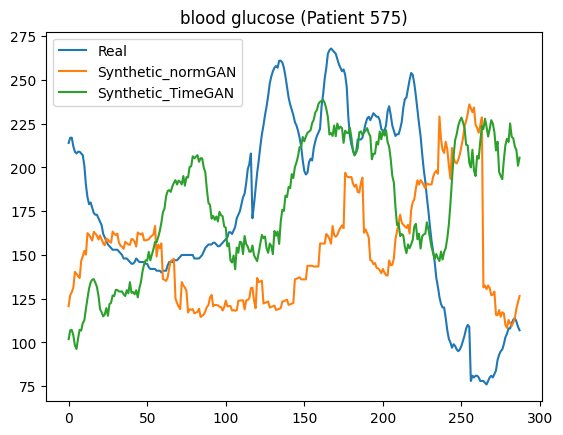

In [ ]:
cols = 'blood glucose (Patient 575)'

df = pd.DataFrame({'Real': real_ori[45], 'Synthetic_normGAN': synth_normgan_nonnorm[45], 'Synthetic_TimeGAN': synth_timegan_nonnorm[7][0][45][:, 0]})
df.plot(title = cols,
        secondary_y='Synthetic data', style=['-'])

<Axes: title={'center': 'blood glucose (Patient 575)'}>

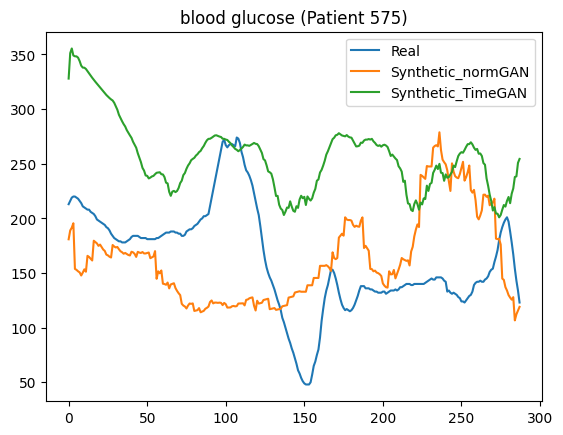

In [ ]:
cols = 'blood glucose (Patient 575)'

df = pd.DataFrame({'Real': real_ori[49], 'Synthetic_normGAN': synth_normgan_nonnorm[49], 'Synthetic_TimeGAN': synth_timegan_nonnorm[7][0][49][:, 0]})
df.plot(title = cols,
        secondary_y='Synthetic data', style=['-'])

<Axes: title={'center': 'blood glucose (Patient 575)'}>

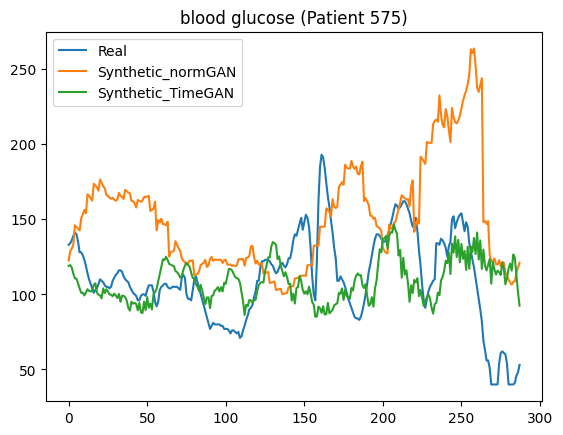

In [ ]:
cols = 'blood glucose (Patient 575)'

df = pd.DataFrame({'Real': real_ori[52], 'Synthetic_normGAN': synth_normgan_nonnorm[52], 'Synthetic_TimeGAN': synth_timegan_nonnorm[7][0][52][:, 0]})
df.plot(title = cols,
        secondary_y='Synthetic data', style=['-'])

JS distance and DTW

In [ ]:
# Wilcoxon test
res_normgan = wilcoxon(synth_normgan_nonnorm, real_ori, alternative = 'two-sided', zero_method='wilcox')
res_timegan = wilcoxon([synth_timegan_nonnorm[7][0][i][:,0] for i in range(54)], real_ori, alternative = 'two-sided', zero_method='wilcox')
print('Normal GAN Wiloxon test: {}'.format(mean(res_normgan.pvalue.flatten())))
print('TimeGAN Wiloxon test: {}'.format(mean(res_timegan.pvalue.flatten())))

# JS distance
dis_normgan = distance.jensenshannon(synth_normgan_nonnorm, real_ori, axis=1)
dis_timegan = distance.jensenshannon([synth_timegan_nonnorm[7][0][i][:,0] for i in range(54)], real_ori, axis=1)
print('Normal JS distance: {}'.format(mean(dis_normgan.flatten())))
print('TimeGAN JS distance: {}'.format(mean(dis_timegan.flatten())))

# Eculidean distance
e_dis_norm = [math.dist(synth_normgan_norm[i], glucose_575[i]) for i in range(len(real_ori))]
e_dis_time = [math.dist([synth_timegan_norm[7][0][j][:,0] for j in range(54)][i], glucose_575[i]) for i in range(len(real_ori))]
print('Normal Eculidean distance: {}'.format(mean(e_dis_norm)))
print('TimeGAN Eculidean distance: {}'.format(mean(e_dis_time)))

Normal GAN Wiloxon test: 0.10736801804055726
TimeGAN Wiloxon test: 0.2624882969154612
Normal JS distance: 0.1465386699833888
TimeGAN JS distance: 0.13188081492545886
Normal Eculidean distance: 4.365941809299902
TimeGAN Eculidean distance: 4.380136386256785


In [ ]:
# DTW
dtw_normgan = []
dtw_timegan = []
for i in range(len(real_ori)):
  dtw_normgan.append(dtw.distance(synth_normgan_norm[i], glucose_575[i]))
  dtw_timegan.append(dtw.distance([synth_timegan_norm[7][0][i][:,0] for i in range(54)][i], glucose_575[i]))

print('Normal DTW distance: {}'.format(mean(dtw_normgan)))
print('TimeGAN DTW distance: {}'.format(mean(dtw_timegan)))

Normal DTW distance: 2.271171913043719
TimeGAN DTW distance: 3.410862351236155


visualization of PCA and t-SNE

In [ ]:
sample_size = 54
idx = np.random.permutation(len(real_ori))[:sample_size]

real_sample = np.asarray(real_ori)[idx]

synthetic_sample_norm = np.asarray(synth_normgan_nonnorm)[idx]

synth_data_reduced = real_sample.reshape(-1, 288)
patient_data_reduced_norm = np.asarray(synthetic_sample_norm).reshape(-1,288)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(synth_data_reduced)

pca_real = pd.DataFrame(pca.transform(synth_data_reduced))
pca_synth_norm = pd.DataFrame(pca.transform(patient_data_reduced_norm))

data_reduced = np.concatenate((synth_data_reduced, patient_data_reduced_norm), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

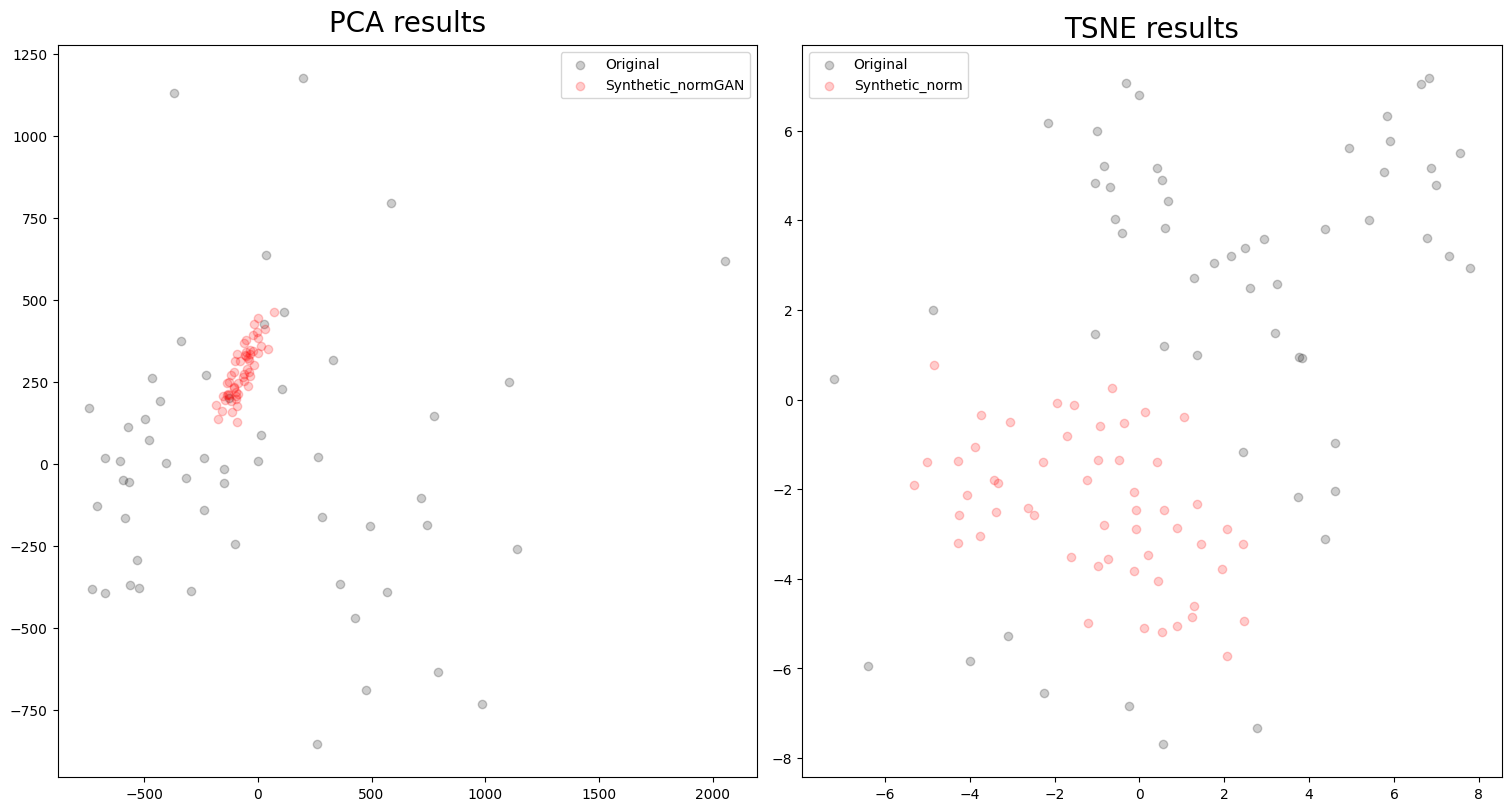

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15,8))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth_norm.iloc[:,0], pca_synth_norm.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic_normGAN')

ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic_norm')

ax2.legend()

In [ ]:
sample_size = 54
idx = np.random.permutation(len(real_ori))[:sample_size]

real_sample = np.asarray(real_ori)[idx]

synthetic_sample_timegan = np.asarray([synth_timegan_nonnorm[7][0][i][:,0] for i in range(54)])[idx]

synth_data_reduced = real_sample.reshape(-1, 288)
patient_data_reduced_timegan = np.asarray(synthetic_sample_timegan).reshape(-1,288)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(synth_data_reduced)

pca_real = pd.DataFrame(pca.transform(synth_data_reduced))
pca_synth_timegan = pd.DataFrame(pca.transform(patient_data_reduced_timegan))

data_reduced = np.concatenate((synth_data_reduced, patient_data_reduced_timegan), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

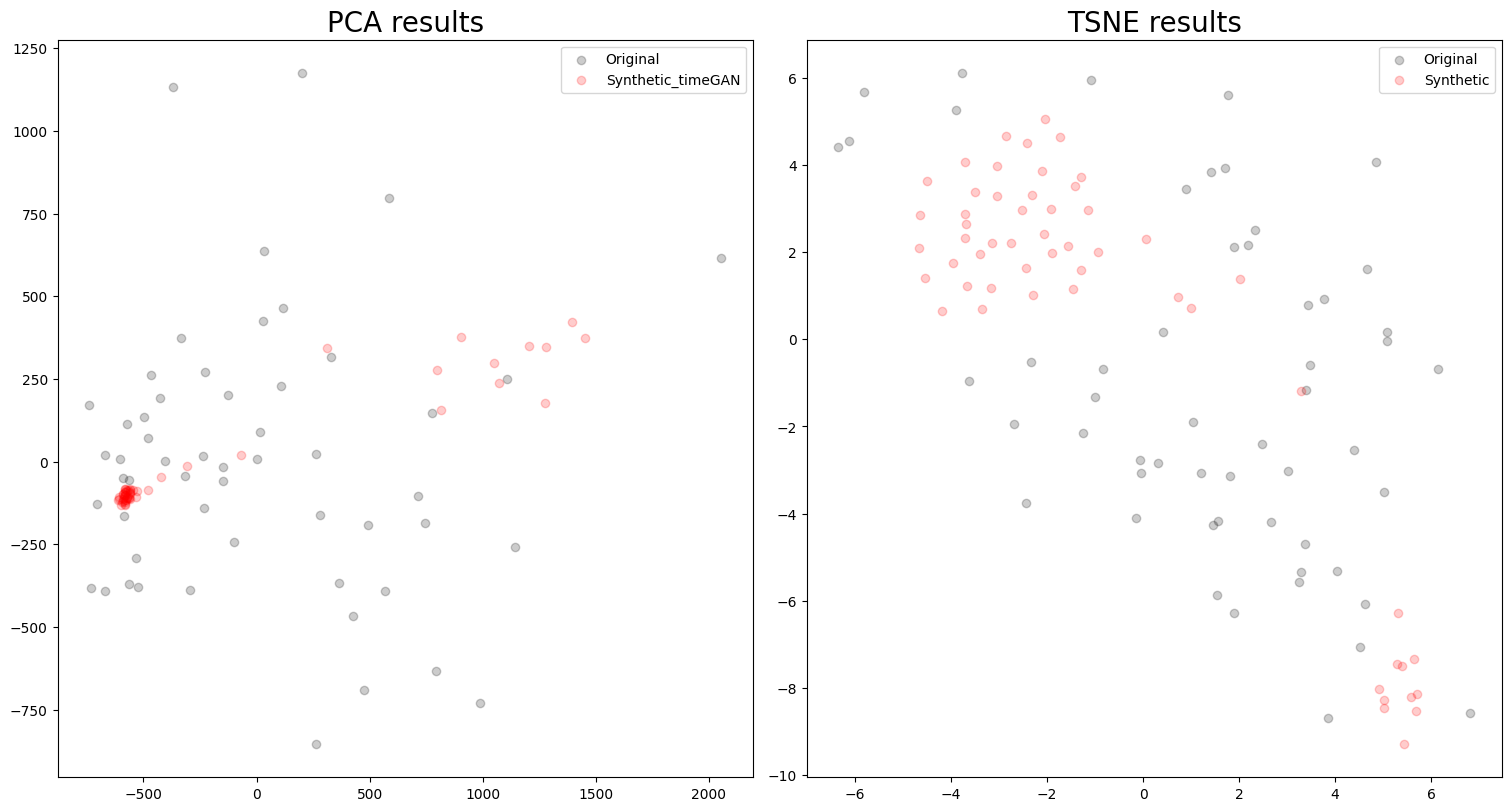

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15,8))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth_timegan.iloc[:,0], pca_synth_timegan.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic_timeGAN')

ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

#fig.suptitle('Validating synthetic vs real data diversity and distributions',
#             fontsize=16)